# COVID-19 Face Mask Detector Model

The COVID-19 face mask detector model is a simple and efficient method of detecting a face mask on human face from a given image or video (coming soon). 

### Purpose

*  To create a face mask binary classifier using convolutional neural networks
*  To explore Keras library
*  To conduct a performance test on popular CNN architectures






### Google Colab drive setup

To establish efficient workflow, I decided to use Google Colaboratory, which allows me to mount my google drive, read, modify and delete data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Initial Imports

In [3]:
import os      
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Select model architecture and set up the initial learning rate, number of epochs, batch size, and data augmentation.


In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception 
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import MobileNetV2

# Data directory
BASE_DIR = "/content/drive/My Drive/face-mask-project/keras-mask/"
IMG_DIR = "/content/drive/My Drive/face-mask-project/keras-mask/Mask_Datasets/Train"
MODELS_DIR = "/content/drive/My Drive/face-mask-project/keras-mask/Models/"
PLOTS_DIR = "/content/drive/My Drive/face-mask-project/keras-mask/Plots/"

MODELS = {
	"vgg16": VGG16,
	"vgg19": VGG19,
	"inception": InceptionV3,
	"xception": Xception, 
	"resnet": ResNet50,
  "mobilenet" : MobileNetV2
}

INIT_LR = 0.0001 # Initial Learning Rate
EPOCHS = 10 
BS = 32 # Batch size
current_model = "xception" 
augmentData = True

##Choose network's input image shape and its preprocessing function based on selected architecture.

In [17]:
from tensorflow.keras.applications.inception_v3 import preprocess_input # preprocessing input InceptionV3 and Xception
from tensorflow.keras.applications import imagenet_utils # preprocessing input VGG, ResNet50, MobileNetV2

# initialize the input image shape (224x224 pixels) along with
# the pre-processing function which changes based on the model we use to classify our image
inputShape = (224, 224)
preprocess = imagenet_utils.preprocess_input
# if we are using the InceptionV3 or Xception networks, then we
# need to set the input shape to (299x299) and use a different image processing function
if current_model in ("inception", "xception"):
  inputShape = (299, 299)
  preprocess = preprocess_input


##Load images from the drive.

In [18]:
from imutils import paths
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("Loading images...Please wait.")
imagePaths = list(paths.list_images(IMG_DIR))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
  # extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
  image = load_img(imagePath, target_size=inputShape)
  image = img_to_array(image)
  image = preprocess(image)
	# update the data and labels lists, respectively
  data.append(image)
  labels.append(label)

print(f"Finished loading {len(imagePaths)} images.")
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
print(f"Found: {data.shape[0]} images of ({data.shape[1]}x{data.shape[2]}x{data.shape[3]}) dimensions.")

Loading images...Please wait.
Finished loading 1100 images.
Found: 1100 images of (299x299x3) dimensions.


##One-Hot Encode Labels and split the data into Train and Test.

In [19]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing using 80/20 ratio
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

##Construct training image generator to augment current data.

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Data Augmentation
# construct the training image generator for data augmentation
if augmentData:
  aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
  
  train_gen = aug.flow(trainX, trainY, batch_size=BS)

##Initialize the model with pre-loaded weights.

In [21]:
from tensorflow.keras.layers import Input

base_model = MODELS[current_model](weights = "imagenet", 
                                   include_top = False,
                                   input_tensor = Input( shape=(299, 299, 3) ))

# loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in base_model.layers:
	layer.trainable = False                                   

##Expand the model for binary classification.

In [22]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

# construct the head of the model that will be placed on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=base_model.input, outputs=head_model)

##Compile the model with Adam optimizer.

In [23]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

##Fit the model on the training set or augmented data.

In [24]:
from tensorflow.keras.callbacks import LearningRateScheduler

def decay_schedule(epoch, lr):
    # decay by 0.1 every 5 epochs; use `% 1` to decay after each epoch
    if (epoch % 5 == 0) and (epoch != 0):
        lr = lr * 10
    return lr

# Initialize the Learning Rate Scheduler, which increases by 10 each five epochs
lr_scheduler = LearningRateScheduler(decay_schedule)

# train the head of the network
print("Training...")
if augmentData:
  history = model.fit(
      train_gen,
      epochs = EPOCHS,
      steps_per_epoch= len(trainX) // BS,
      validation_data= (testX, testY),
      validation_steps = len(testX) // BS,
      verbose=2,
      callbacks = [lr_scheduler])
else:
  history = model.fit(
      trainX,
      trainY,
      epochs = EPOCHS,
      steps_per_epoch = len(trainX) // BS,
      validation_data = (testX, testY),
      validation_steps = len(testX) // BS,
      verbose=2,
      callbacks = [lr_scheduler])


Training...
Epoch 1/10
27/27 - 25s - loss: 0.4763 - accuracy: 0.7901 - val_loss: 0.2229 - val_accuracy: 0.9864 - lr: 1.0000e-04
Epoch 2/10
27/27 - 25s - loss: 0.2106 - accuracy: 0.9682 - val_loss: 0.1013 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 3/10
27/27 - 25s - loss: 0.1270 - accuracy: 0.9788 - val_loss: 0.0614 - val_accuracy: 0.9955 - lr: 1.0000e-04
Epoch 4/10
27/27 - 24s - loss: 0.0991 - accuracy: 0.9835 - val_loss: 0.0441 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/10
27/27 - 24s - loss: 0.0829 - accuracy: 0.9835 - val_loss: 0.0334 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/10
27/27 - 25s - loss: 0.0476 - accuracy: 0.9906 - val_loss: 0.0081 - val_accuracy: 1.0000 - lr: 1.0000e-03
Epoch 7/10
27/27 - 25s - loss: 0.0219 - accuracy: 0.9953 - val_loss: 0.0033 - val_accuracy: 1.0000 - lr: 1.0000e-03
Epoch 8/10
27/27 - 25s - loss: 0.0155 - accuracy: 0.9965 - val_loss: 0.0033 - val_accuracy: 1.0000 - lr: 1.0000e-03
Epoch 9/10
27/27 - 25s - loss: 0.0199 - accuracy: 0.9965 - v

##Evaluate the model.

In [25]:
from sklearn.metrics import classification_report
# make predictions on the testing set
print("Evaluating network...")
predictions = model.predict(testX, batch_size=BS)
# for each image in the predictions find label's index with the largest probability
predictions = np.argmax(predictions, axis=1)
# show a classification report
print(classification_report(testY.argmax(axis=1), predictions, target_names=lb.classes_))

Evaluating network...
              precision    recall  f1-score   support

        Mask       1.00      1.00      1.00       100
     No_mask       1.00      1.00      1.00       120

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220



### Save the model to the disk.

In [26]:
# save the model to disk
print("Saving mask detector model...")

# Save model with a name depending on data augmentation
if not augmentData:
    aug_name = "-no-aug"
    file_name = current_model + aug_name
    model.save(MODELS_DIR + file_name, save_format="h5")  
else:
    file_name = current_model
    model.save(MODELS_DIR + file_name, save_format="h5")

print(f'Saved to {MODELS_DIR + file_name}.')

Saving mask detector model...
Saved to /content/drive/My Drive/face-mask-project/keras-mask/Models/xception.


## Plotting training history.

### Save training history to drive

In [ ]:
import pickle

# serialize the training history to disk
print("serializing training history...")
f = open(BASE_DIR + "history-" + file_name + ".txt", "wb")
f.write(pickle.dumps(history.history))
f.close()

### Plot Accuracy and Loss Curves.

In [103]:
# load the training history
H = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-" + file_name + ".txt", "rb").read())

n_epochs = len(H['loss']) # number of epochs 

# Create functions to plot Accuracy and Loss curves
def plot_history(loss, val_loss, accuracy, val_accuracy):
  N = n_epochs
  plt.style.use("seaborn-darkgrid")
  fig = plt.figure(figsize=(200,100))
  fig.add_subplot(30, 24, 1)
  plt.plot(np.arange(1, N+1), loss, label="Train")
  plt.plot(np.arange(1, N+1), val_loss, label="Test")
  plt.title(file_name.title() + " Loss Function")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.yticks(np.arange(0, max(H["loss"]) + 0.1, step=0.1)) 
  plt.legend(loc="center right")
  #plt.savefig(PLOTS_DIR + file_name + "-loss_plot.png")
  fig.add_subplot(30, 24, 2)
  plt.plot(np.arange(1, N+1), accuracy, label="Train")
  plt.plot(np.arange(1, N+1), val_accuracy, label="Test")
  plt.title(file_name.title() + " Accuracy Function")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.yticks(np.arange(min(H["accuracy"]) - 0.2, max(H["accuracy"]) + 0.05, step=0.1)) 
  plt.legend(loc="center right")
  plt.show()
  #plt.savefig(PLOTS_DIR + file_name + "-acc_plot.png")

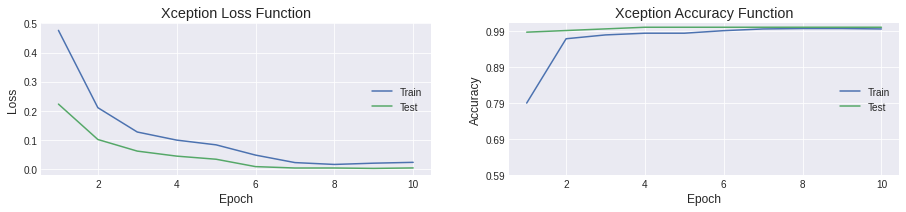

In [104]:
plot_history(H["loss"], H["val_loss"], H["accuracy"], H["val_accuracy"])

### Display Confusion Matrix.

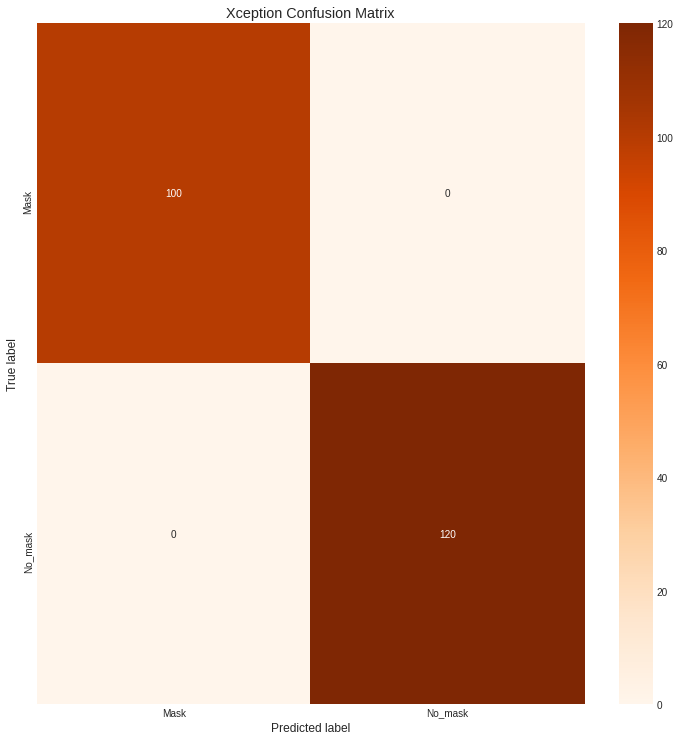

In [108]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(testY.argmax(axis=1), predictions)

cm = tf.math.confusion_matrix(labels=testY.argmax(axis=1), predictions=predictions).numpy()
con_mat_df = pd.DataFrame(cm,
                     index = lb.classes_, 
                     columns = lb.classes_)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, 
            annot=True,cmap=plt.cm.Oranges, 
            fmt='d')

plt.tight_layout()
plt.title(file_name.title() + " Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(PLOTS_DIR + file_name + "-cf.png")
plt.show()

### Display Accuracies and Losses for all architectures.

In [109]:
H_vgg16_no_aug = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-vgg16-no-aug.txt", "rb").read())
H_vgg16 = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-vgg16.txt", "rb").read())
H_vgg19_no_aug = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-vgg19-no-aug.txt", "rb").read())
H_vgg19 = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-vgg19.txt", "rb").read())
H_resnet_no_aug = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-resnet-no-aug.txt", "rb").read())
H_resnet = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-resnet.txt", "rb").read())
H_mobilenet_no_aug = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-mobilenet-no-aug.txt", "rb").read())
H_mobilenet = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-mobilenet.txt", "rb").read())
H_inception_no_aug = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-inception-no-aug.txt", "rb").read())
H_inception = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-inception.txt", "rb").read())
H_xception_no_aug = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-xception-no-aug.txt", "rb").read())
H_xception = pickle.loads(open("/content/drive/My Drive/face-mask-project/keras-mask/history-xception.txt", "rb").read())

In [110]:
def plot_accuracies():
  N = n_epochs
  plt.style.use("seaborn")
  NUM_COLORS = 12

  cm = plt.get_cmap('gist_ncar')
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
 
  ax.plot(np.arange(1, N+1), H_vgg16_no_aug["accuracy"], label="VGG16 no aug")
  ax.plot(np.arange(1, N+1), H_vgg16["accuracy"], label="VGG16")
  ax.plot(np.arange(1, N+1), H_vgg19_no_aug["accuracy"], label="VGG19 no aug")
  ax.plot(np.arange(1, N+1), H_vgg19["accuracy"], label="VGG19")
  ax.plot(np.arange(1, N+1), H_resnet_no_aug["accuracy"], label="ResNet no aug")
  ax.plot(np.arange(1, N+1), H_resnet["accuracy"], label="ResNet")
  ax.plot(np.arange(1, N+1), H_mobilenet_no_aug["accuracy"], label="MobileNetV2 no aug")
  ax.plot(np.arange(1, N+1), H_mobilenet["accuracy"], label="MobileNetV2")
  ax.plot(np.arange(1, N+1), H_inception_no_aug["accuracy"], label="InceptionV3 no aug")
  ax.plot(np.arange(1, N+1), H_inception["accuracy"], label="InceptionV3")
  ax.plot(np.arange(1, N+1), H_xception_no_aug["accuracy"], label="Xception no aug")
  ax.plot(np.arange(1, N+1), H_xception["accuracy"], label="Xception")
  
  plt.title("Accuracies plot for different architectures")
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="best")
  plt.savefig(PLOTS_DIR + "accuracies.png")


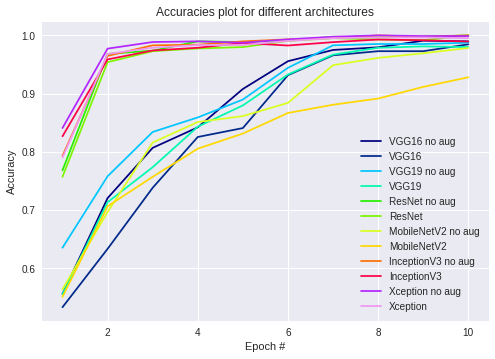

In [111]:
plot_accuracies()

In [112]:
def plot_losses():
  N = n_epochs
  plt.style.use("seaborn")
  NUM_COLORS = 12

  cm = plt.get_cmap('gist_ncar')
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

  ax.plot(np.arange(1, N+1), H_vgg16_no_aug["loss"], label="VGG16 no aug")
  ax.plot(np.arange(1, N+1), H_vgg16["loss"], label="VGG16")
  ax.plot(np.arange(1, N+1), H_vgg19_no_aug["loss"], label="VGG19 no aug")
  ax.plot(np.arange(1, N+1), H_vgg19["loss"], label="VGG19")
  ax.plot(np.arange(1, N+1), H_resnet_no_aug["loss"], label="ResNet no aug")
  ax.plot(np.arange(1, N+1), H_resnet["loss"], label="ResNet")
  ax.plot(np.arange(1, N+1), H_mobilenet_no_aug["loss"], label="MobileNetV2 no aug")
  ax.plot(np.arange(1, N+1), H_mobilenet["loss"], label="MobileNetV2")
  ax.plot(np.arange(1, N+1), H_inception_no_aug["loss"], label="InceptionV3 no aug")
  ax.plot(np.arange(1, N+1), H_inception["loss"], label="InceptionV3")
  ax.plot(np.arange(1, N+1), H_xception_no_aug["loss"], label="Xception no aug")
  ax.plot(np.arange(1, N+1), H_xception["loss"], label="Xception")
  
  plt.title("Loss values for different architectures")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="best")
  plt.savefig(PLOTS_DIR + "losses.png")


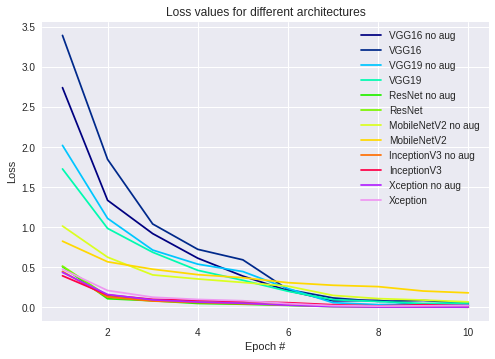

In [113]:
plot_losses()

### Display Barplot of accuracies for different architectures.

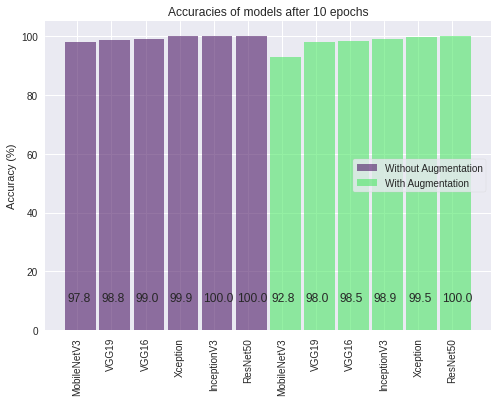

In [116]:
# Create bars
barWidth = 0.9
bars1 = [H_vgg16_no_aug["accuracy"][-1],
         H_vgg19_no_aug["accuracy"][-1],
         H_resnet_no_aug["accuracy"][-1],
         H_mobilenet_no_aug["accuracy"][-1],
         H_inception_no_aug["accuracy"][-1],
         H_xception_no_aug["accuracy"][-1] ]

bars1 = sorted(list(np.array(bars1) * 100))

bars2 = [H_vgg16["accuracy"][-1],
         H_vgg19["accuracy"][-1],
         H_resnet["accuracy"][-1],
         H_mobilenet["accuracy"][-1],
         H_inception["accuracy"][-1],
         H_xception["accuracy"][-1] ]

bars2 = sorted(list(np.array(bars2) * 100))

# The X position of bars
r1 = [1,2,3,4,5,6]
r2 = [7,8,9,10,11,12]
r4 = r1 + r2
# Create barplot
fig = plt.figure()
fig.add_subplot(1,1,1)
plt.bar(r1, bars1, width = barWidth, color = (0.3,0.1,0.4,0.6), label='Without Augmentation')
plt.bar(r2, bars2, width = barWidth, color = (0.3,0.9,0.4,0.6), label='With Augmentation')
# Note: the barplot could be created easily. See the barplot section for other examples.

plt.title("Accuracies of models after 10 epochs")
# Create legend
plt.legend(loc="center right", frameon = True)
plt.ylabel("Accuracy (%)")

# Text below each barplot with a rotation at 90°
plt.xticks([r + barWidth for r in range(len(r4))], ['MobileNetV3', 'VGG19', 'VGG16', 'Xception', 'InceptionV3', 'ResNet50', 'MobileNetV3', 'VGG19', 'VGG16', 'InceptionV3', 'Xception', 'ResNet50' ], rotation=90)
 
# Create labels
top_labels = bars1 + bars2

#formatted_labels = [ np.round(elem, 3) for elem in labels ]
labels_formatted = list(np.around(np.array(top_labels),1))

# Text on the top of each barplot
for i in range(len(r4)):
  plt.text(x = r4[i]-0.4 , y = 10, s = labels_formatted[i], size = 12)
 
# Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)

# Save
plt.savefig(PLOTS_DIR + "barplot.png")

# Show graphic
plt.show()


## Code Snippets for Image capture in Google Colab

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Load Face detection and Face mask detection models

#### Detecting faces

In [195]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import cv2
from deepface.basemodels import VGGFace
from deepface.commons import functions
from google.colab.patches import cv2_imshow

# load our serialized face detector model from disk
print("loading face detector model...")
prototxtPath = os.path.sep.join(["/content/drive/My Drive/face-mask-project/keras-mask/face_detector", "deploy.prototxt"])
weightsPath = os.path.sep.join(["/content/drive/My Drive/face-mask-project/keras-mask/face_detector",
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector model from disk
print("loading face mask detector model...")
maskNet = load_model("/content/drive/My Drive/face-mask-project/keras-mask/Models/inception")

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread('/content/photo.jpg')
orig = image.copy()
(h, w) = image.shape[:2]
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))
# pass the blob through the network and obtain the face detections
print("computing face detections...")
net.setInput(blob)
detections = net.forward()

loading face detector model...
loading face mask detector model...
computing face detections...


In [168]:
detections[0,0,69,2]

0.0

#### Applying mask classifier on detected faces

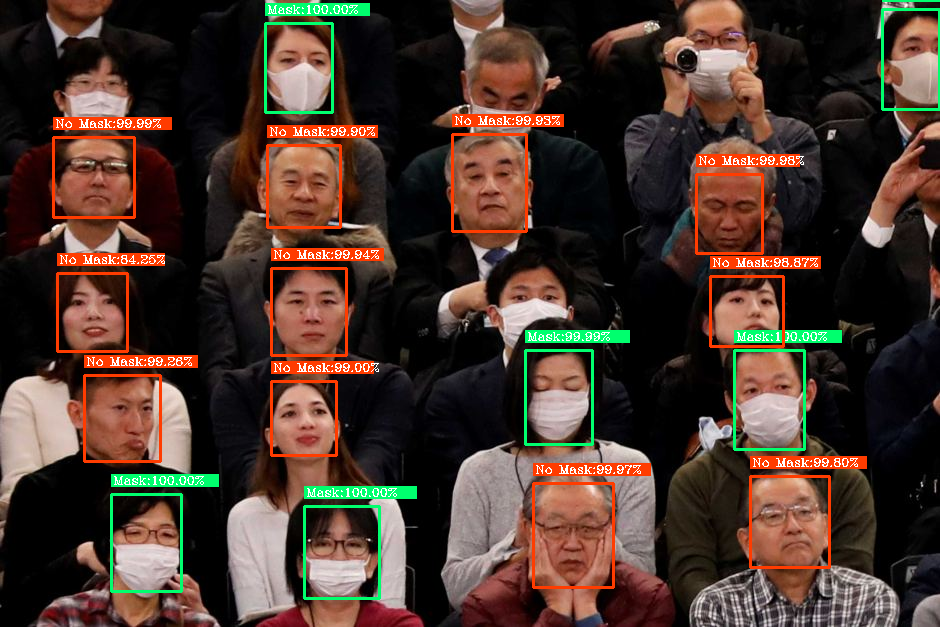

-1

In [196]:
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]
	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.4:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))
  
    # extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 299x299, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (299, 299))
		face = img_to_array(face)
		face = preprocess(face)
		face = np.expand_dims(face, axis=0)
		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = maskNet.predict(face)[0]

    # determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (110, 255, 0) if label == "Mask" else (0, 60, 255)
		# include the probability in the label
		label = "{}:{:.2f}%".format(label, max(mask, withoutMask) * 100)
		# display the label and bounding box rectangle on the output
		# frame
		x,y,wid,hei = startX, startY, endX, endY - startY
		cv2.rectangle(image, (x, y - 20), (wid + 37, y - 8), color, -1)
		cv2.putText(image, label, (startX+2, startY - 10), cv2.FONT_HERSHEY_COMPLEX, 0.4, (255,255,255), 1)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)